In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
import itertools
import pickle

2025-01-07 16:41:14.358961: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 16:41:14.383437: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 16:41:14.634356: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 16:41:14.754801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736268075.044164  202267 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736268075.18

In [4]:
# load data
data = pd.read_csv("../0_DataPreparation/Data/model_train_20130701_20180731.csv")

# convert dates
data['Datum'] = pd.to_datetime(data['Datum'])
data

id      Datum      Umsatz  KielerWoche  weekend_or_holiday  \
0     1307011 2013-07-01  148.828353            0                   0   
1     1307021 2013-07-02  159.793757            0                   0   
2     1307031 2013-07-03  111.885594            0                   0   
3     1307041 2013-07-04  168.864941            0                   0   
4     1307051 2013-07-05  171.280754            0                   0   
...       ...        ...         ...          ...                 ...   
9329  1712216 2017-12-21   87.471228            0                   0   
9330  1712226 2017-12-22   71.911652            0                   0   
9331  1712236 2017-12-23   84.062223            0                   1   
9332  1712246 2017-12-24   60.981969            0                   1   
9333  1712276 2017-12-27   34.972644            0                   0   

      wetter_regen  wetter_schnee  wetter_gewitter  wetter_dunst  \
0                0              0                0             0   
1                0              0                0             0   
2                1              0                0             0   
3                0              0                0             0   
4                0              0                0             0   
...            ...            ...              ...           ...   
9329             0              0                0             0   
9330             0              0                0             1   
9331             1              0                0             0   
9332             1              0                0             0   
9333             0              0                0             0   

      wetter_nebel  ...  Monat_May  Monat_November  Monat_October  \
0                0  ...          0               0              0   
1                0  ...          0               0              0   
2                0  ...          0               0              0   
3                0  ...          0               0              0   
4                0  ...          0               0              0   
...            ...  ...        ...             ...            ...   
9329             0  ...          0               0              0   
9330             0  ...          0               0              0   
9331             0  ...          0               0              0   
9332             0  ...          0               0              0   
9333             0  ...          0               0              0   

      Monat_September  is_Montag  is_Dienstag  is_Mittwoch  is_Donnerstag  \
0                   0          1            0            0              0   
1                   0          0            1            0              0   
2                   0          0            0            1              0   
3                   0          0            0            0              1   
4                   0          0            0            0              0   
...               ...        ...          ...          ...            ...   
9329                0          0            0            0              1   
9330                0          0            0            0              0   
9331                0          0            0            0              0   
9332                0          0            0            0              0   
9333                0          0            0            1              0   

      is_Freitag  is_Samstag  
0              0           0  
1              0           0  
2              0           0  
3              0           0  
4              1           0  
...          ...         ...  
9329           0           0  
9330           1           0  
9331           0           1  
9332           0           0  
9333           0           0  

[9334 rows x 45 columns]

In [5]:
# split data to train and validation set
train_data = data[(data['Datum'] >= '2013-07-01') & (data['Datum'] <= '2017-07-31')]
val_data = data[(data['Datum'] > '2017-07-31') & (data['Datum'] <= '2018-08-31')]

# features 
features = [
    'KielerWoche', 'weekend_or_holiday', 
    'wetter_regen','wetter_schnee', 'wetter_gewitter', 'wetter_dunst', 'wetter_nebel',
    'temp_bin_Kalt', 'temp_bin_Moderat', 'temp_bin_Warm', 
    'wind_bin_windstill', 'wind_bin_moderat', 'wind_bin_sturm', 'cloud_Bin_sonnig', 'cloud_Bin_moderat','cloud_Bin_bedeckt',
    'is_silvester',
    'Monat_April', 'Monat_August', 'Monat_December', 'Monat_February',
    'Monat_January', 'Monat_July', 'Monat_June', 'Monat_March', 'Monat_May',
    'Monat_November', 'Monat_October', 'Monat_September',
    'Warengruppe_Broetchen', 'Warengruppe_Brot', 'Warengruppe_Croissant', 'Warengruppe_Konditorei',
    'Warengruppe_Kuchen', 'Warengruppe_Saisonbrot', 
    'inflation', 
    'is_Montag', 'is_Dienstag','is_Mittwoch', 'is_Donnerstag', 'is_Freitag', 'is_Samstag'
]

# target (Umsatz)
target = 'Umsatz'

# scale data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[features])
val_scaled = scaler.transform(val_data[features])

# rename feature and target
x_train = train_scaled
y_train = train_data[target]

x_val = val_scaled
y_val = val_data[target]

In [12]:
tf.keras.backend.clear_session()

# create model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(len(features),), kernel_regularizer=l2(0.001)), 
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    #tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)  # Keine Aktivierungsfunktion im Output
])

# Definiere Huber-Loss mit einem spezifischen Delta-Wert
loss = Huber(delta=25)

# learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=5000,
    decay_rate=0.9)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=loss,
    metrics=['mae']
)

# training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# evaluation
val_loss, val_mae = model.evaluate(x_val, y_val)
print(f'Validation Loss: {val_loss}, Validation MAE: {val_mae}')


Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4851.7988 - mae: 206.5620 - val_loss: 4556.6646 - val_mae: 194.7531
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4781.0913 - mae: 203.7307 - val_loss: 4450.8447 - val_mae: 190.5160
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4681.3818 - mae: 199.7340 - val_loss: 4249.5801 - val_mae: 182.4601
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4491.7070 - mae: 192.1187 - val_loss: 3929.1953 - val_mae: 169.6197
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4146.6660 - mae: 178.2191 - val_loss: 3476.1611 - val_mae: 151.3653
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3713.1882 - mae: 160.7609 - val_loss: 3033.3096 - val_mae: 133.6383
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3208.5171 - mae: 140.4835 - val_loss: 2380.6228 - val_mae: 107.4675
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2609.3943 - mae: 116.3668 - val_loss: 1810.2400 

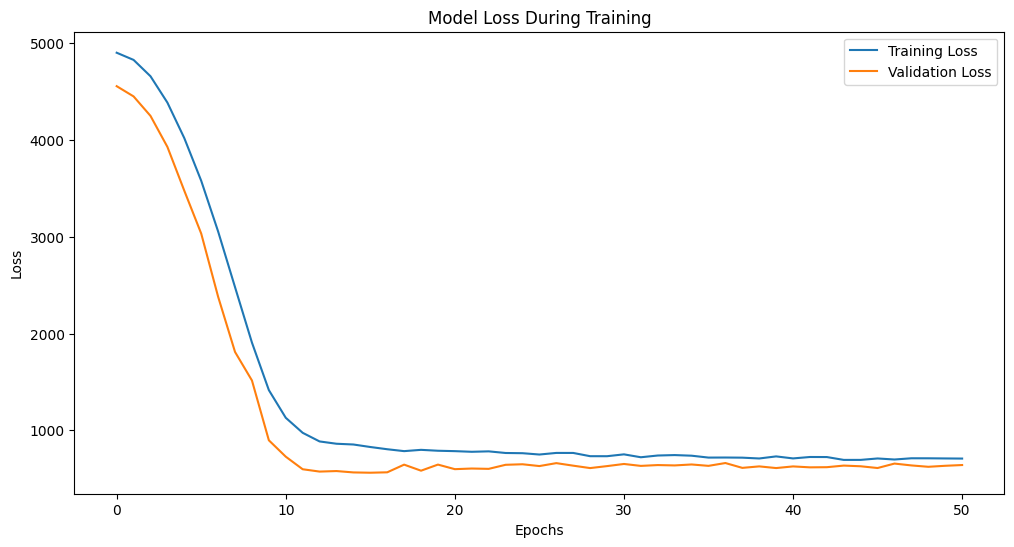

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
training_predictions = model.predict(x_train)
validation_predictions = model.predict(x_val)

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


In [15]:
# DataFrames für Plots aktualisieren
train_predictions_df = pd.DataFrame({
    'Datum': train_data['Datum'],
    'id': train_data['id'],
    'Tatsächlicher Umsatz': y_train,
    'Vorhergesagter Umsatz': training_predictions.flatten()
})

val_predictions_df = pd.DataFrame({
    'Datum': val_data['Datum'],
    'id': val_data['id'],
    'Tatsächlicher Umsatz': y_val,
    'Vorhergesagter Umsatz': validation_predictions.flatten()
})

In [16]:
# Mapping für Warengruppen
ware_mapping = {
    1: 'Brot',
    2: 'Broetchen',
    3: 'Croissant',
    4: 'Konditorei',
    5: 'Kuchen',
    6: 'Saisonbrot'
}

# Spalte 'Datum' und 'Warengruppe' extrahieren
train_predictions_df['Datum'] = pd.to_datetime(train_predictions_df['id'].astype(str).str[:6], format='%y%m%d')
train_predictions_df['Warengruppe'] = train_predictions_df['id'].astype(str).str[-1].astype(int).map(ware_mapping)
train_predictions_df['Jahr'] = train_predictions_df['Datum'].dt.year

# Spalte 'Datum' und 'Warengruppe' extrahieren
val_predictions_df['Datum'] = pd.to_datetime(val_predictions_df['id'].astype(str).str[:6], format='%y%m%d')
val_predictions_df['Warengruppe'] = val_predictions_df['id'].astype(str).str[-1].astype(int).map(ware_mapping)
val_predictions_df['Jahr'] = val_predictions_df['Datum'].dt.year

# MAPE für jede Warengruppe berechnen
def calculate_mape(y_true, y_pred):#(actual, predicted):
    #non_zero_mask = actual != 0
    #return (abs(actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask]).mean() * 100
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

print(f"MAPE on the Training Data: {calculate_mape(train_predictions_df['Tatsächlicher Umsatz'], train_predictions_df['Vorhergesagter Umsatz']):.2f}%")
for group in train_predictions_df['Warengruppe'].unique():
    group_data = train_predictions_df[train_predictions_df['Warengruppe'] == group]
    mape = calculate_mape(group_data['Tatsächlicher Umsatz'], group_data['Vorhergesagter Umsatz'])
    print(f"MAPE für {group}: {mape:.2f}%")


print(f"\n MAPE on the Validation Data: {calculate_mape(val_predictions_df['Tatsächlicher Umsatz'], val_predictions_df['Vorhergesagter Umsatz']):.2f}%")
for group in val_predictions_df['Warengruppe'].unique():
    group_data = val_predictions_df[val_predictions_df['Warengruppe'] == group]
    mape = calculate_mape(group_data['Tatsächlicher Umsatz'], group_data['Vorhergesagter Umsatz'])
    print(f"MAPE für {group}: {mape:.2f}%")

MAPE on the Training Data: 16.46%
MAPE für Brot: 17.36%
MAPE für Broetchen: 11.92%
MAPE für Croissant: 16.41%
MAPE für Konditorei: 20.18%
MAPE für Kuchen: 12.35%
MAPE für Saisonbrot: 42.41%

 MAPE on the Validation Data: 19.17%
MAPE für Brot: 20.01%
MAPE für Broetchen: 12.08%
MAPE für Croissant: 19.27%
MAPE für Konditorei: 24.16%
MAPE für Kuchen: 16.45%
MAPE für Saisonbrot: 44.02%


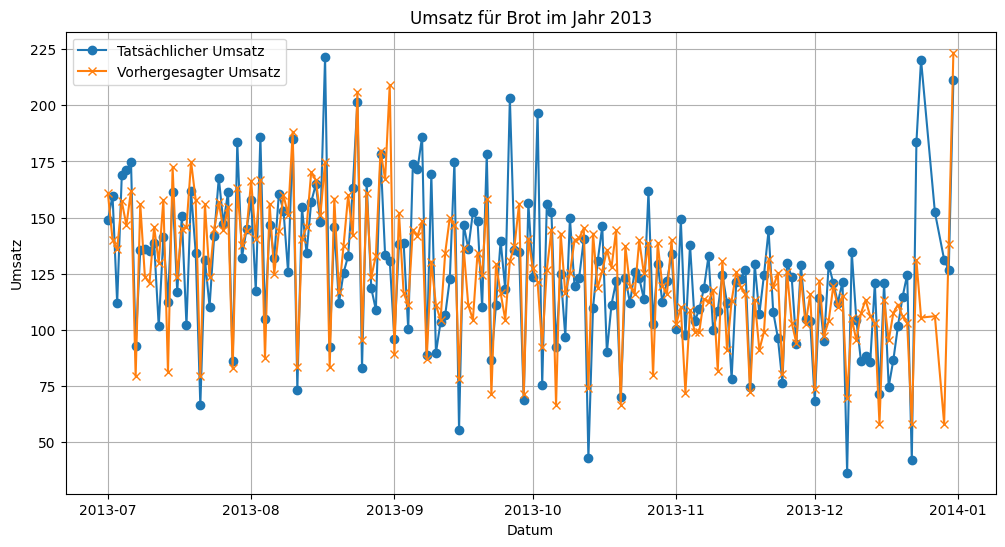

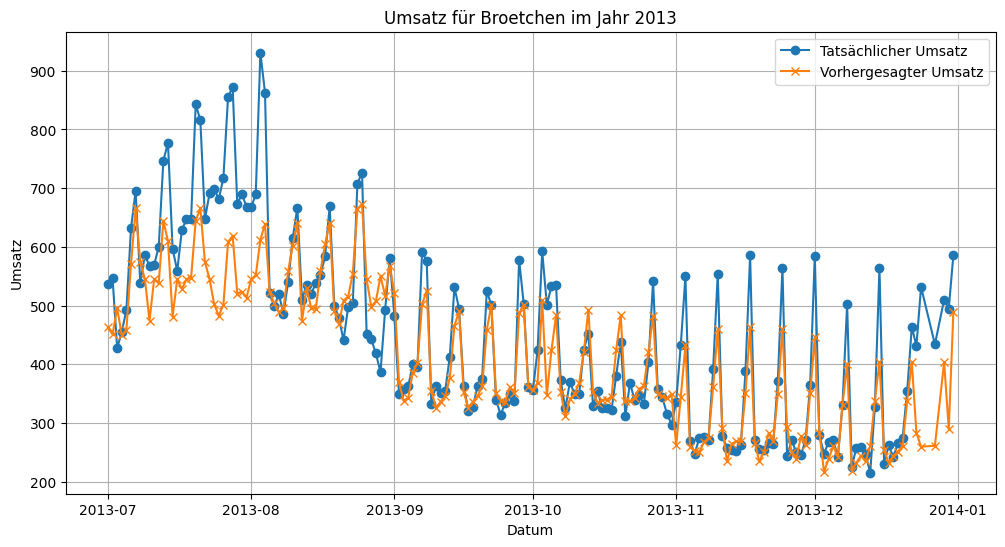

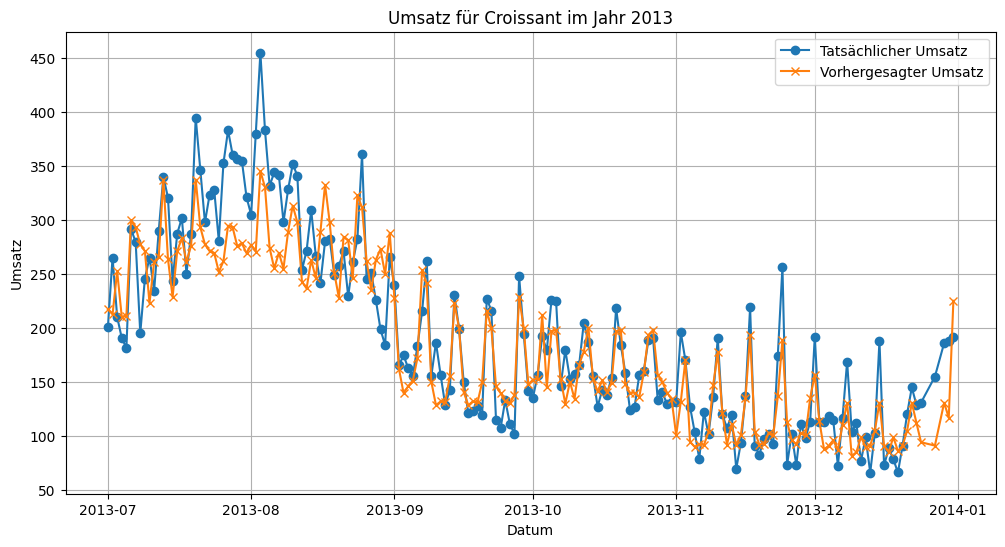

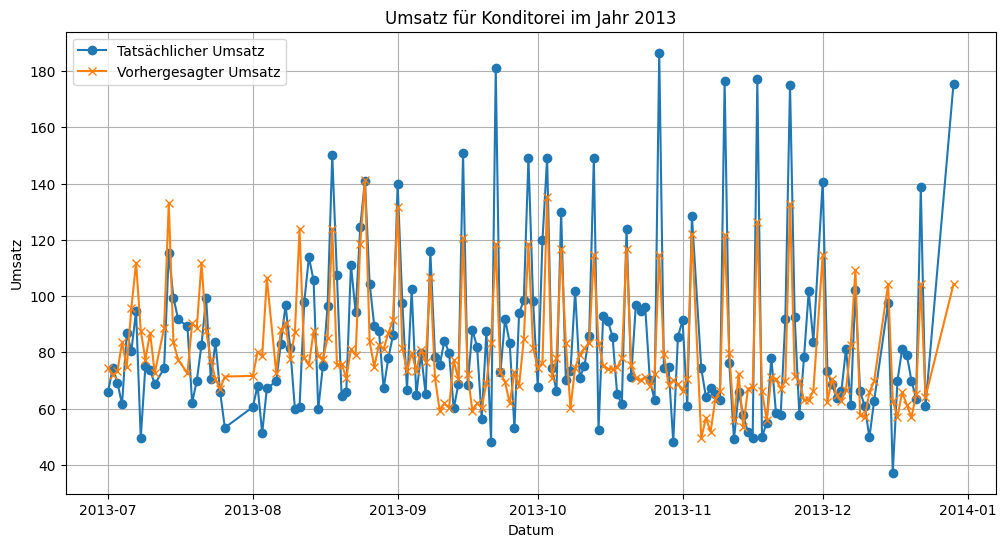

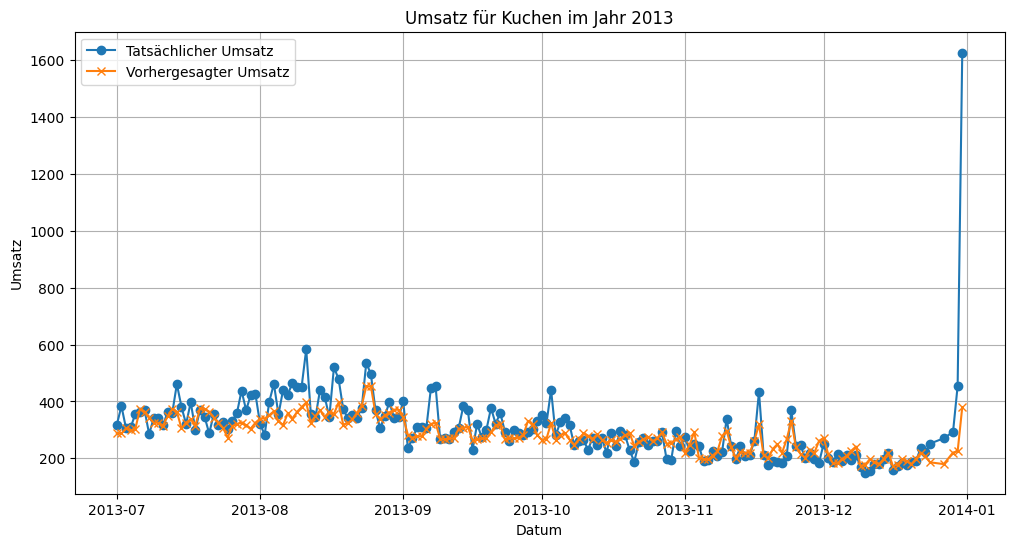

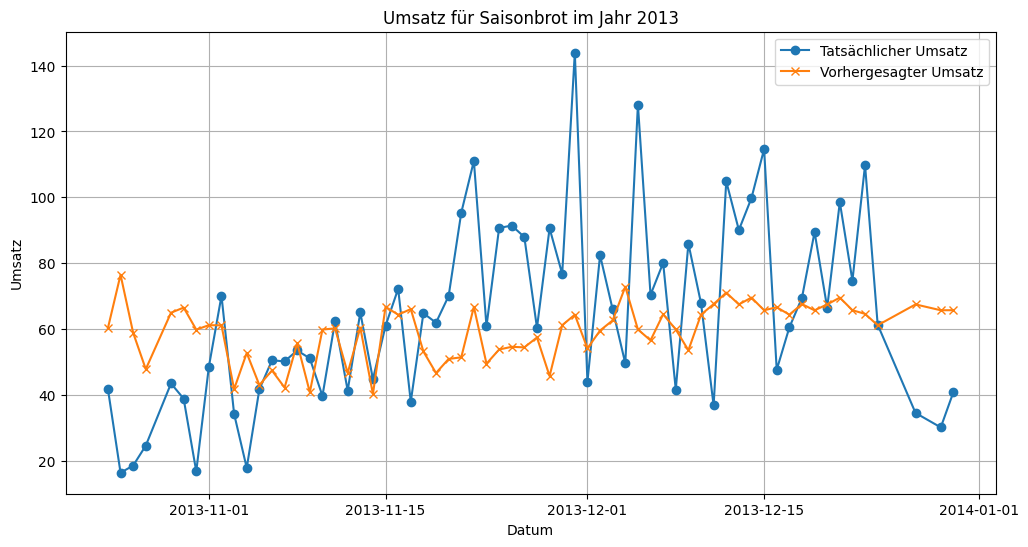

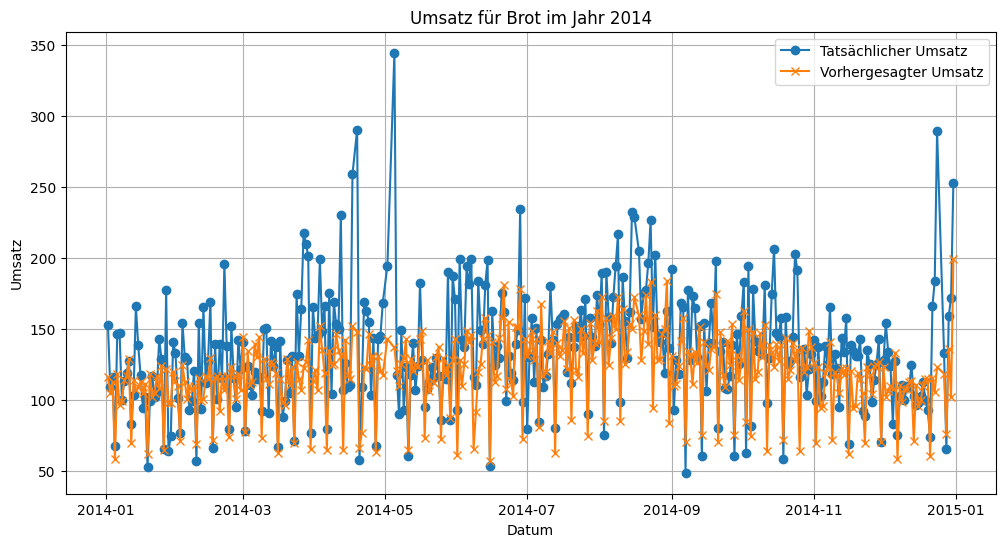

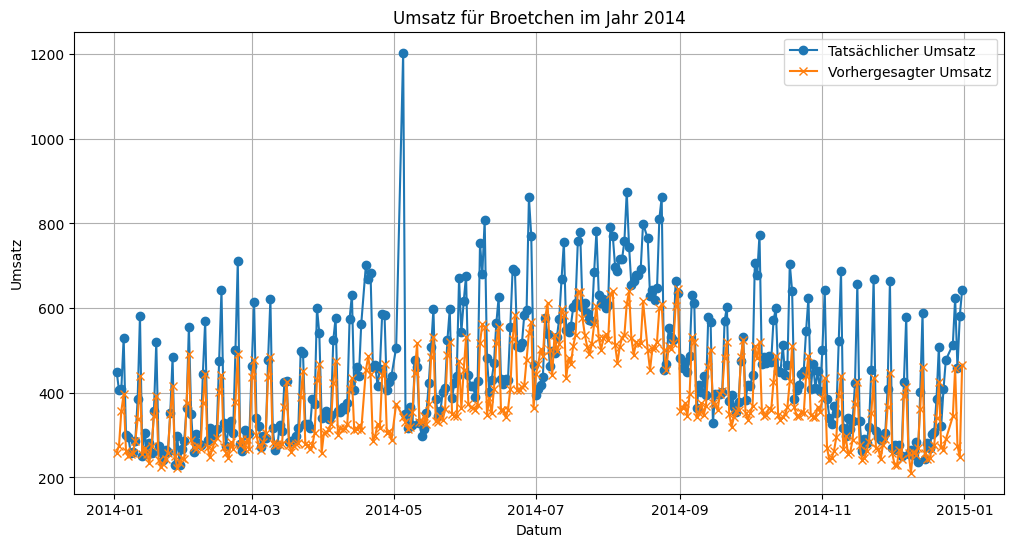

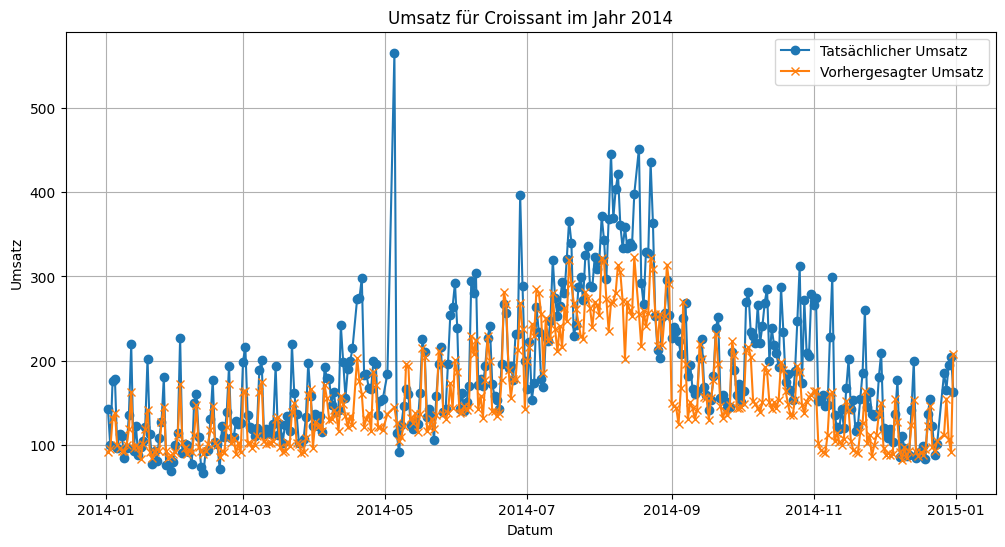

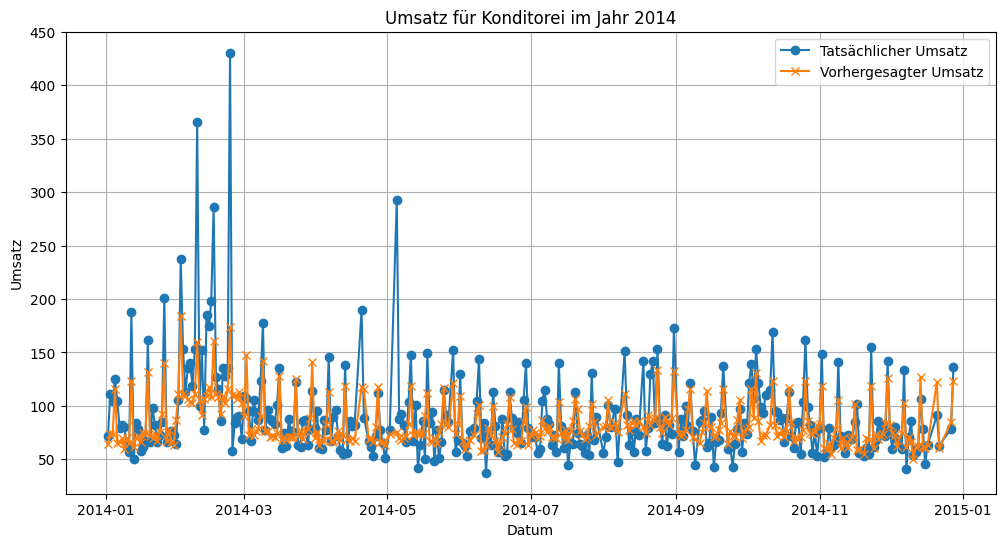

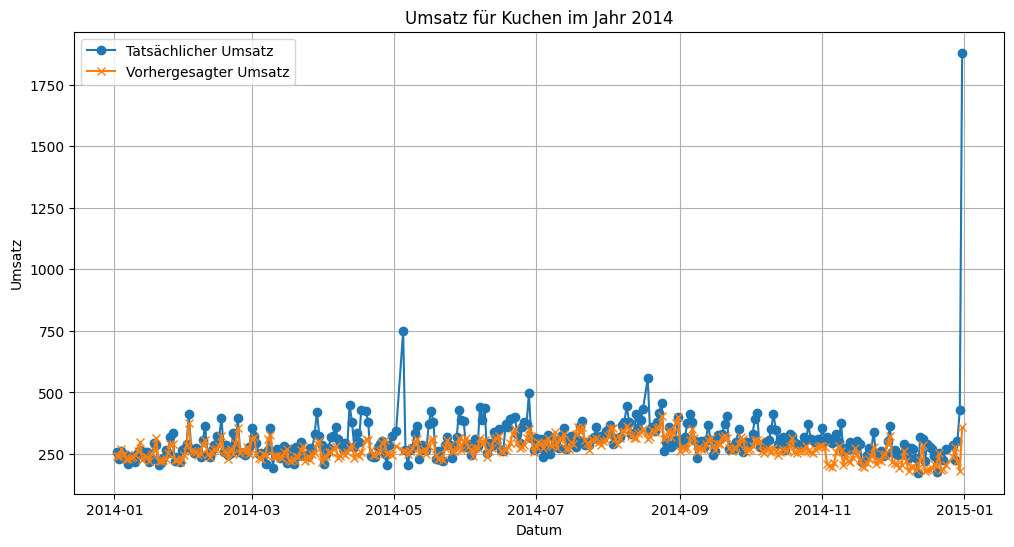

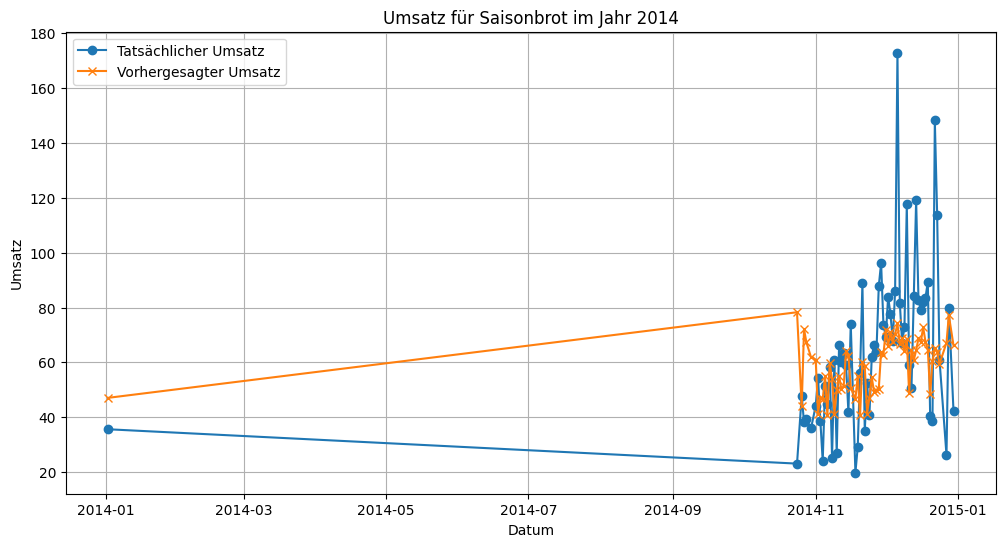

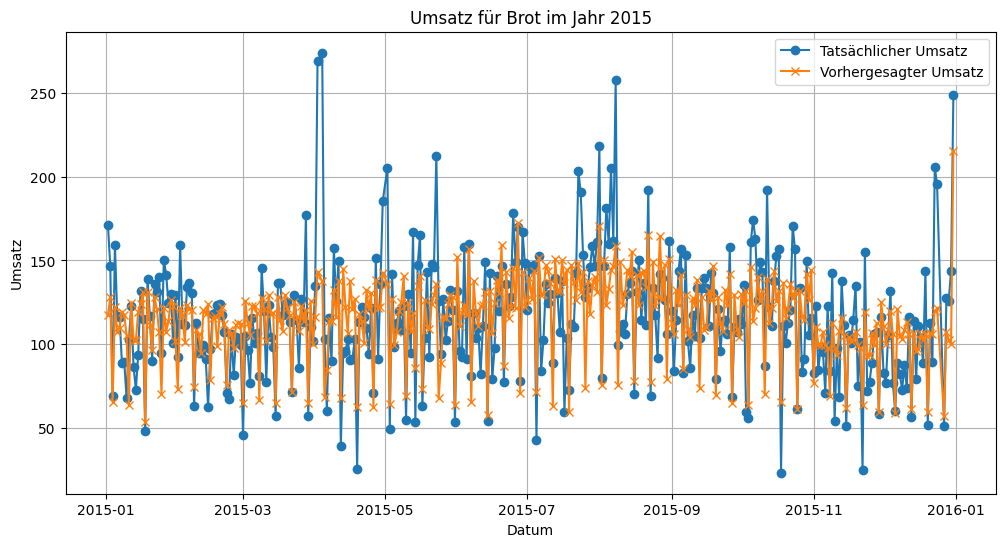

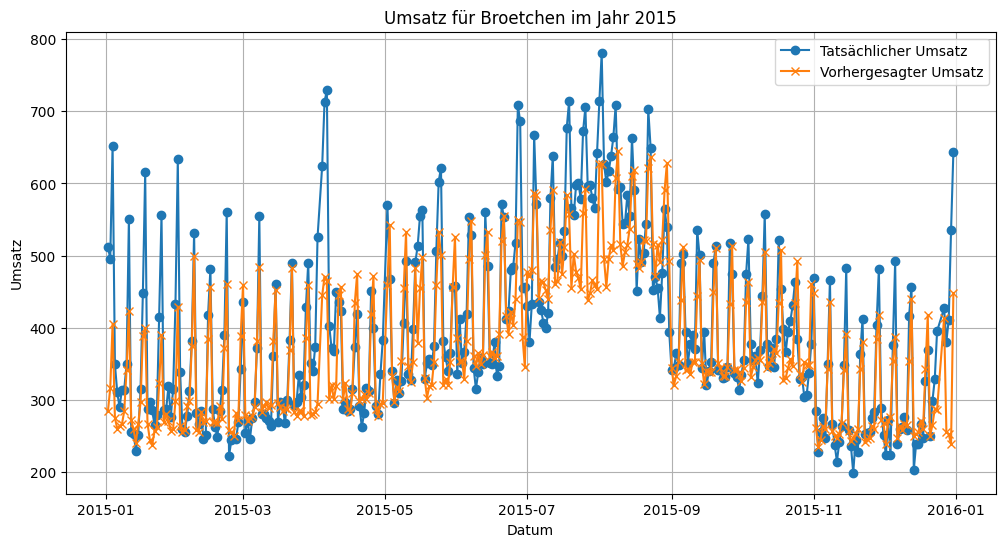

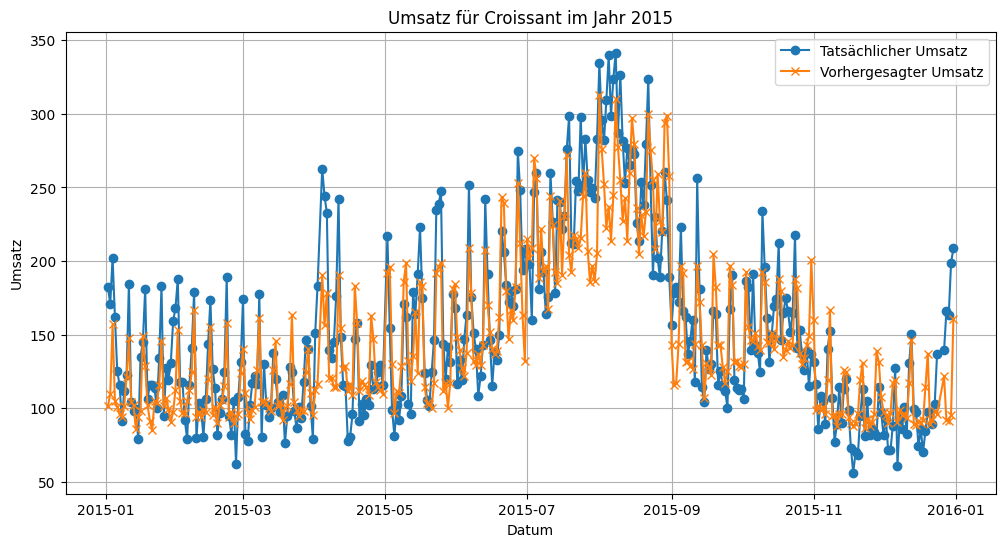

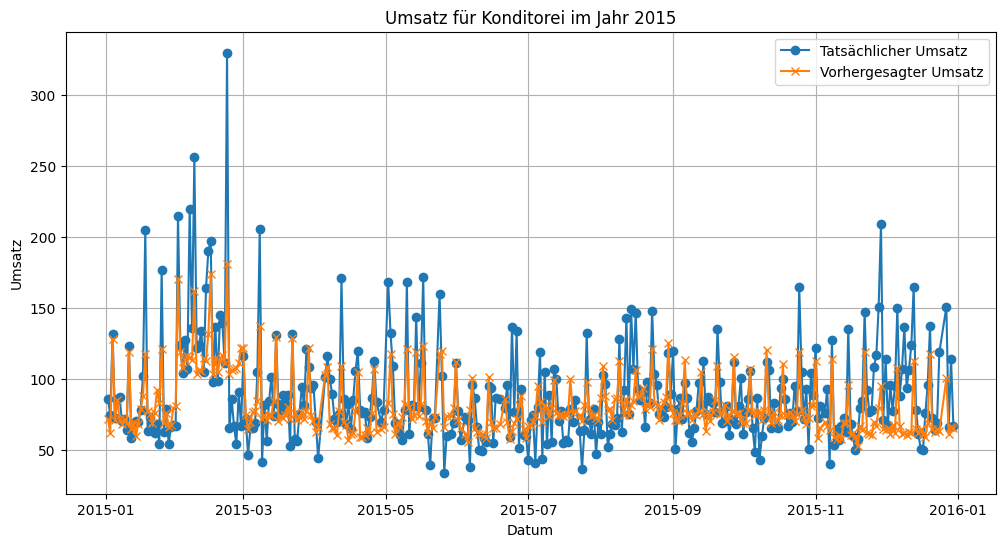

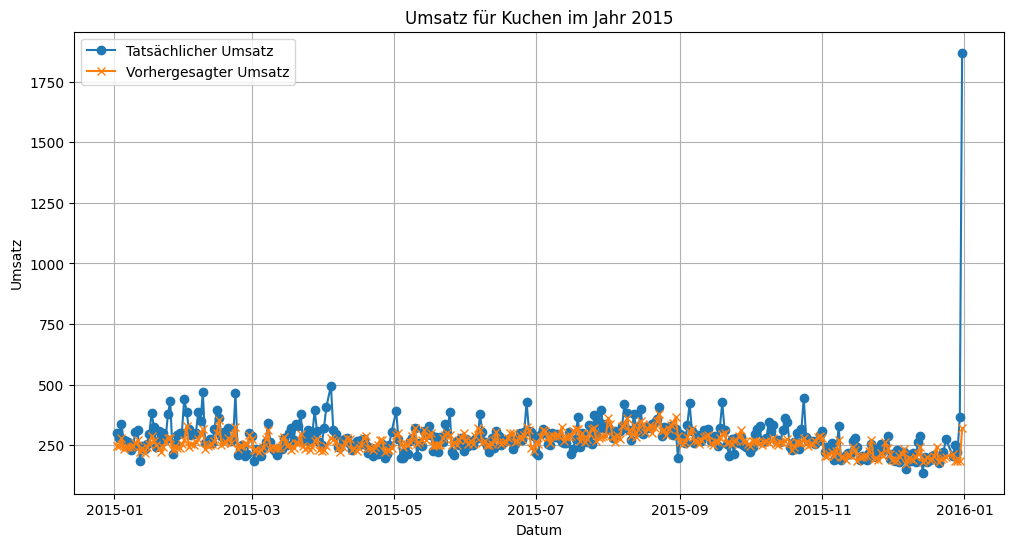

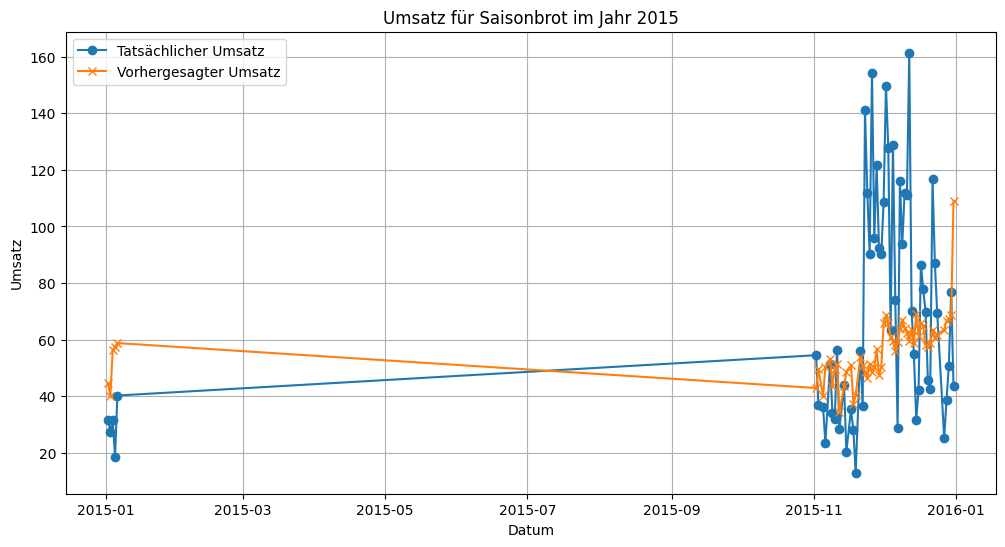

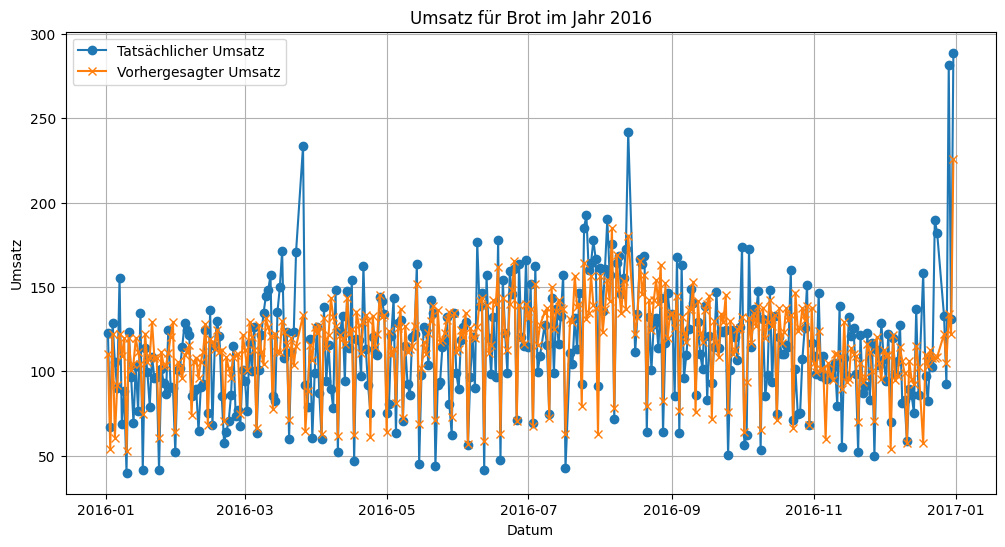

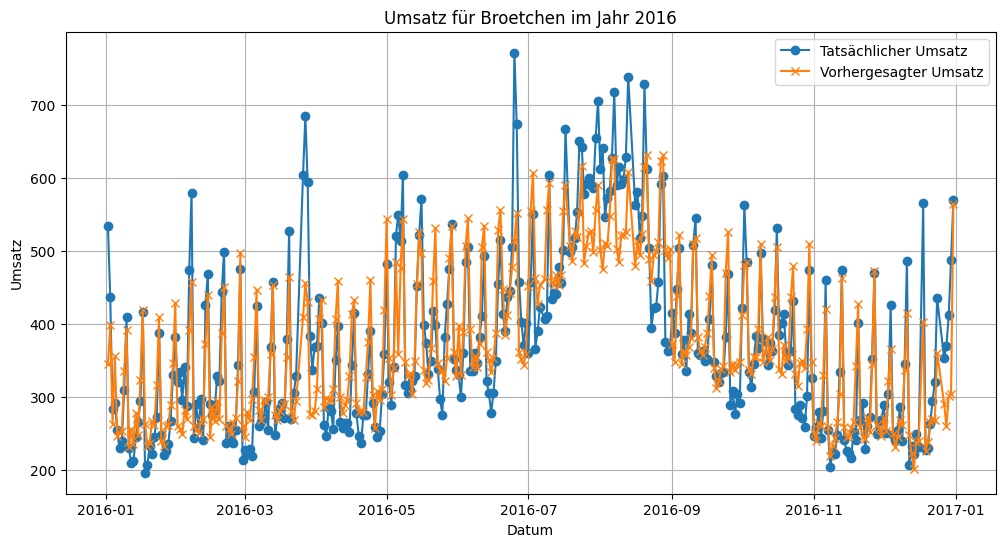

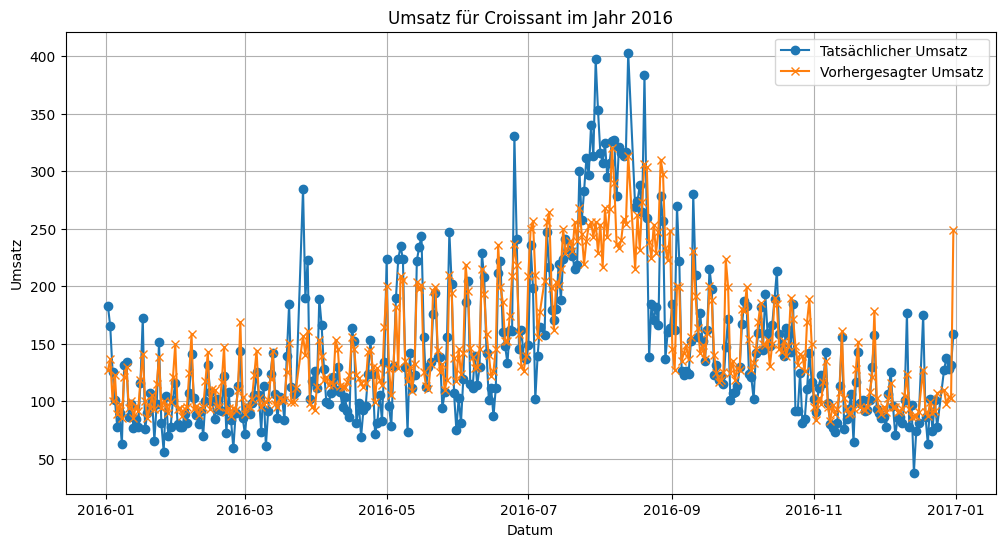

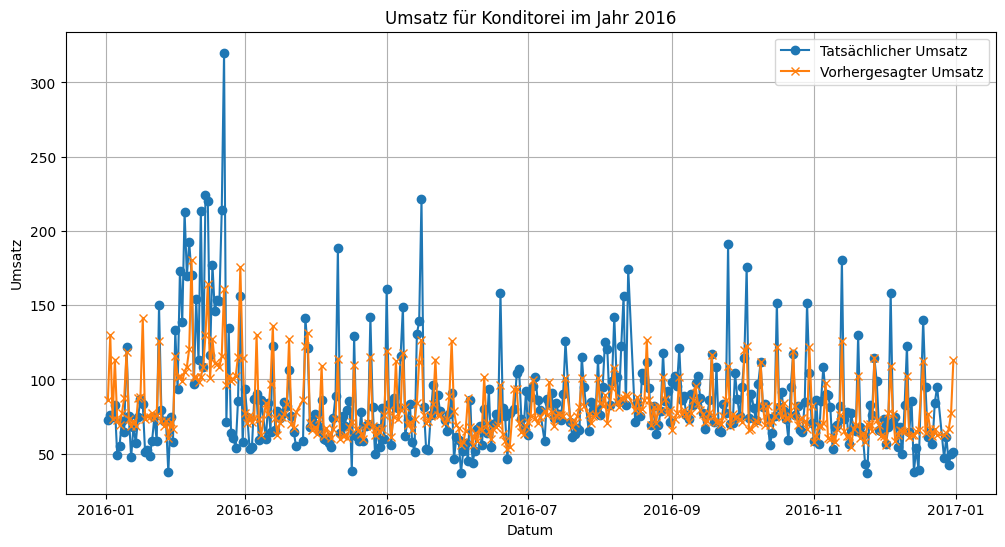

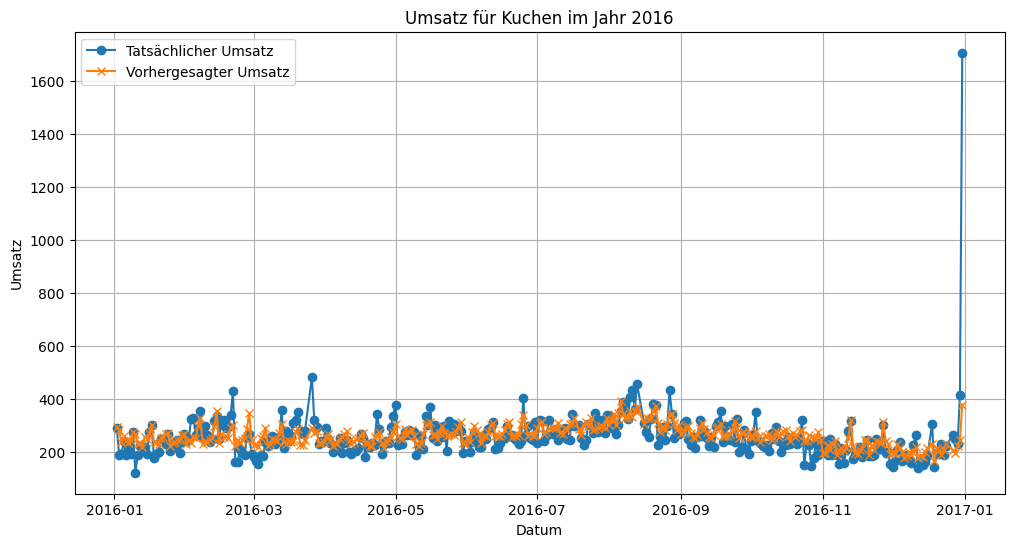

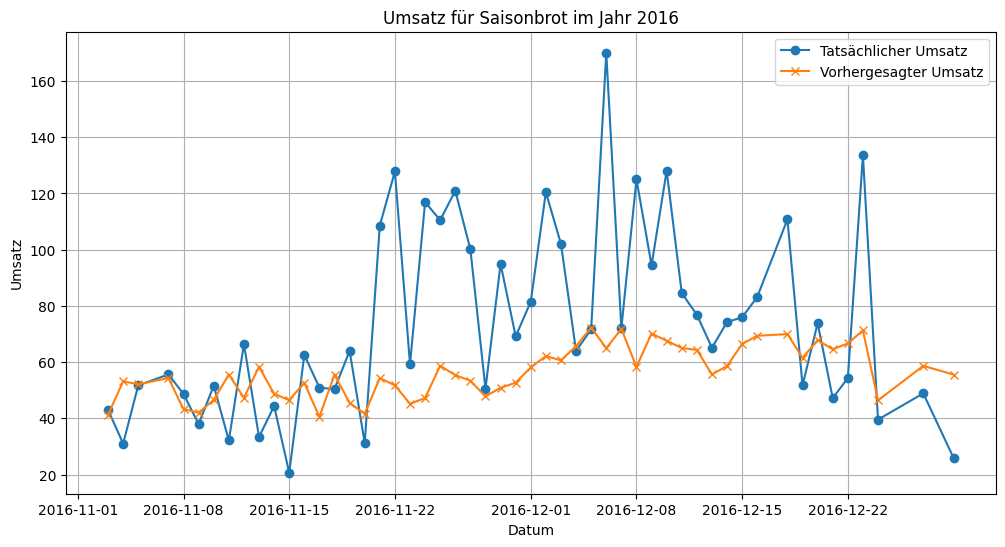

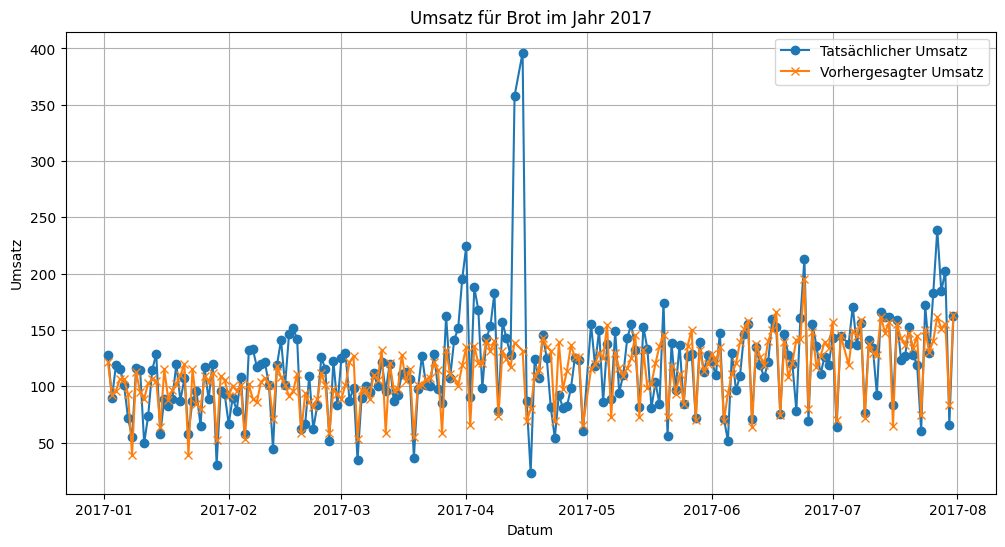

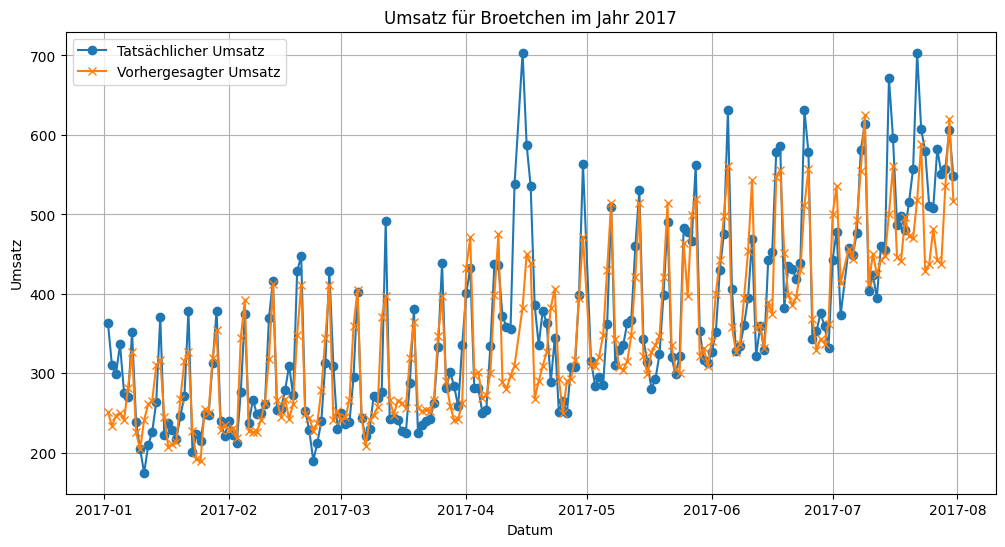

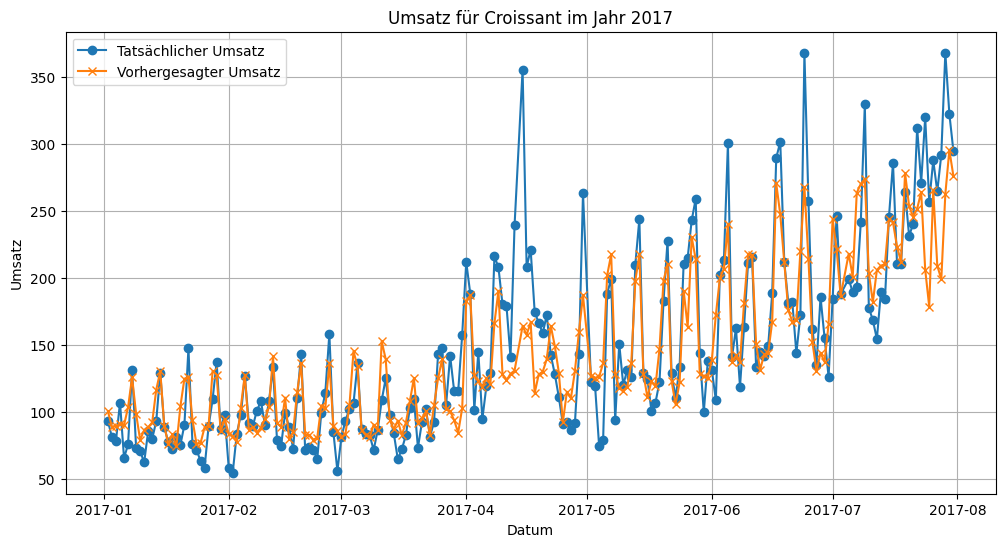

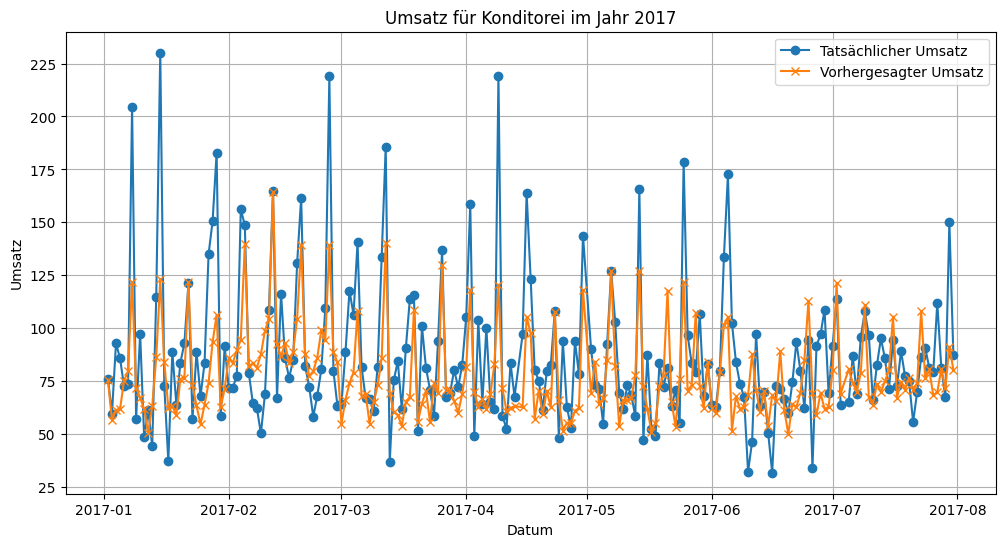

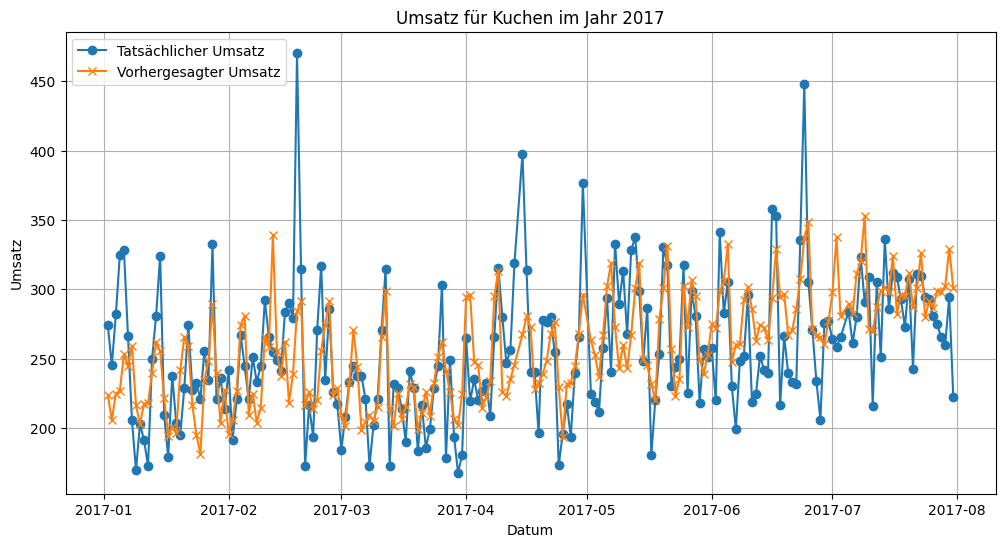

In [17]:
def plot_yearly_sales(df):
    # Liste der Jahre und Warengruppen
    years = sorted(df['Jahr'].unique())
    ware_groups = df['Warengruppe'].unique()

    # Für jedes Jahr und jede Warengruppe aggregieren und plotten
    for year in years:
        for ware_group in ware_groups:
            data = df[(df['Jahr'] == year) & (df['Warengruppe'] == ware_group)]
            
            if data.empty:
                continue
            
            plt.figure(figsize=(12, 6))
            plt.plot(data['Datum'], data['Tatsächlicher Umsatz'], label='Tatsächlicher Umsatz', marker='o')
            plt.plot(data['Datum'], data['Vorhergesagter Umsatz'], label='Vorhergesagter Umsatz', marker='x')
            
            plt.title(f'Umsatz für {ware_group} im Jahr {year}')
            plt.xlabel('Datum')
            plt.ylabel('Umsatz')
            plt.legend()
            plt.grid(True)
            
            plt.show()

plot_yearly_sales(train_predictions_df)

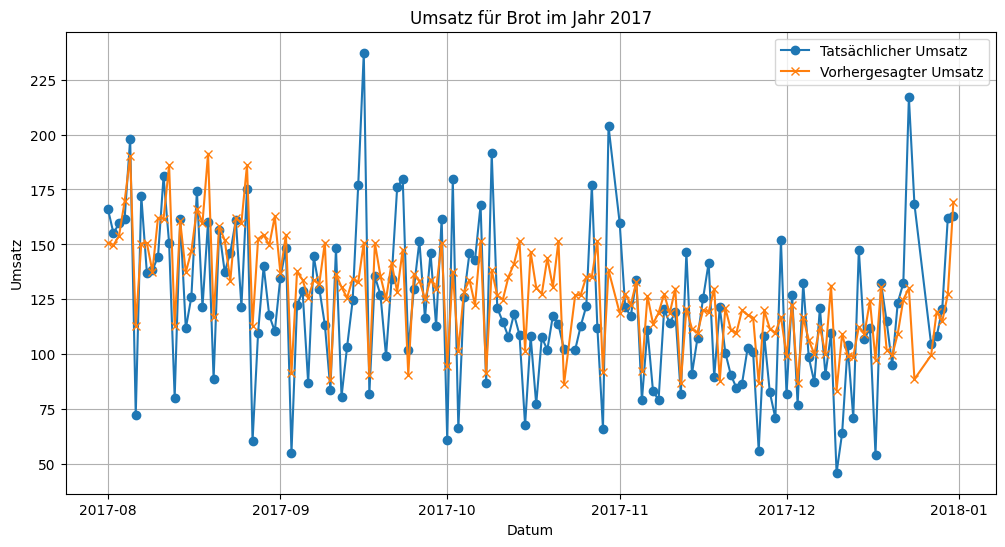

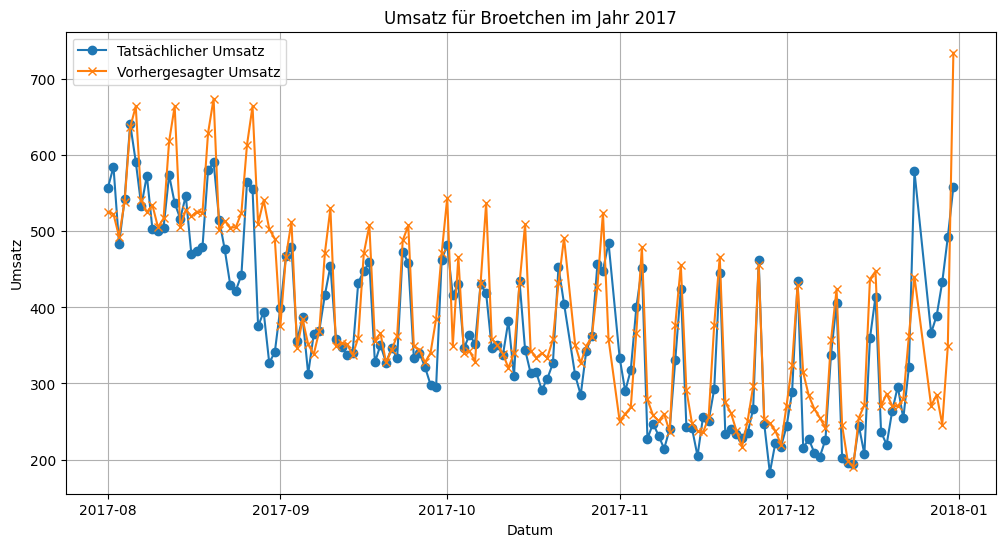

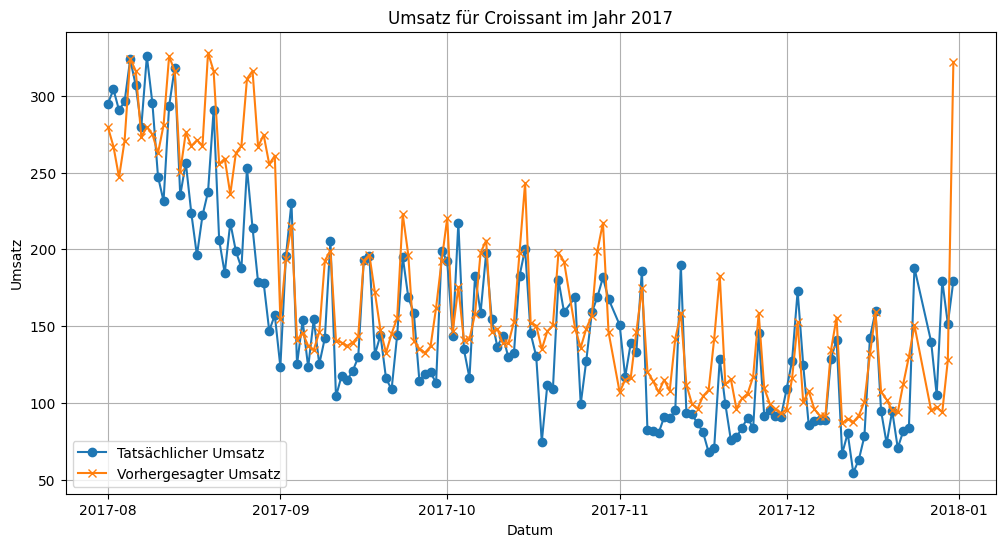

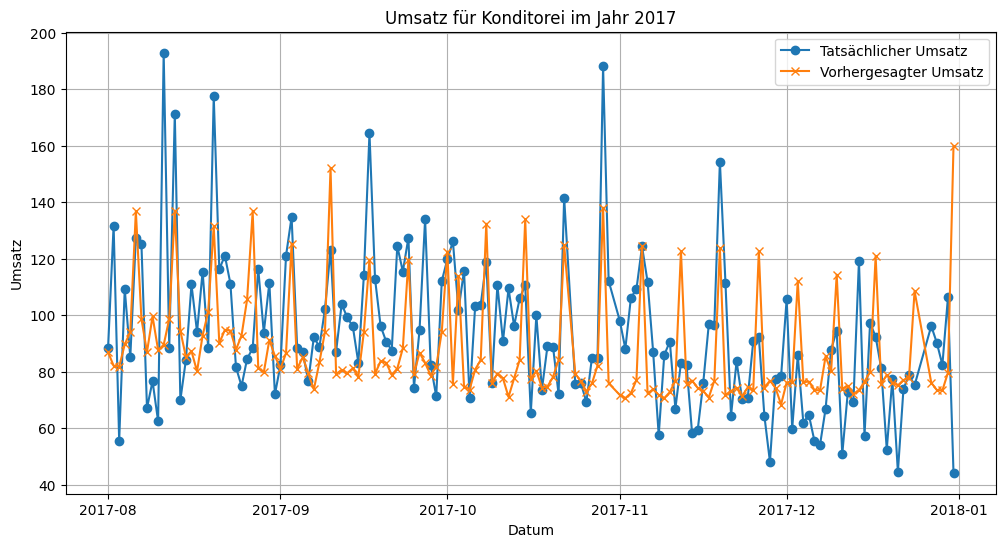

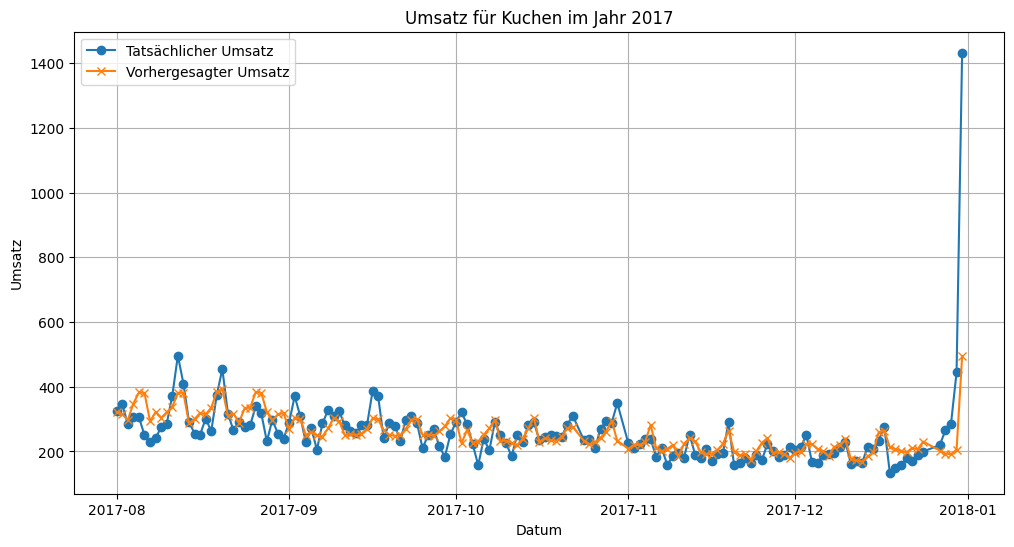

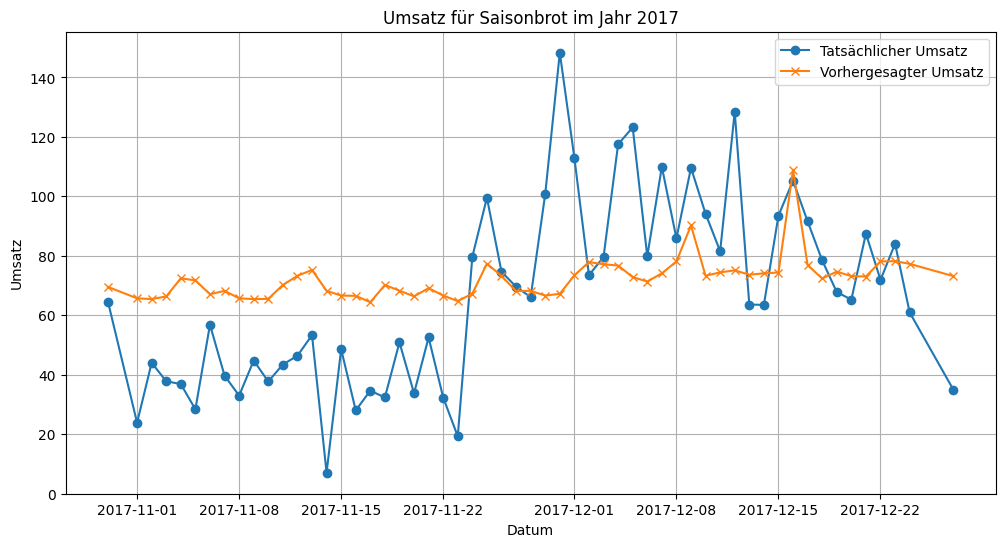

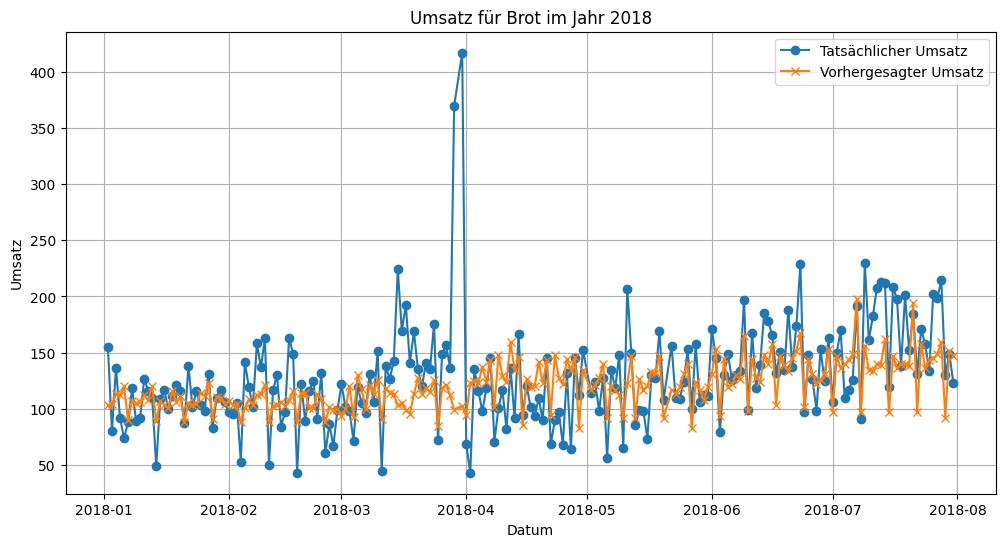

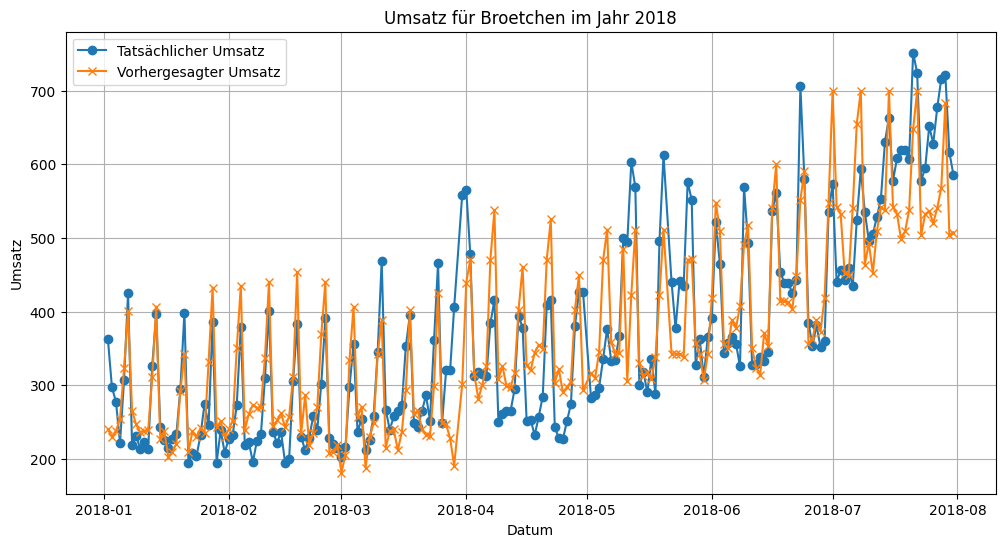

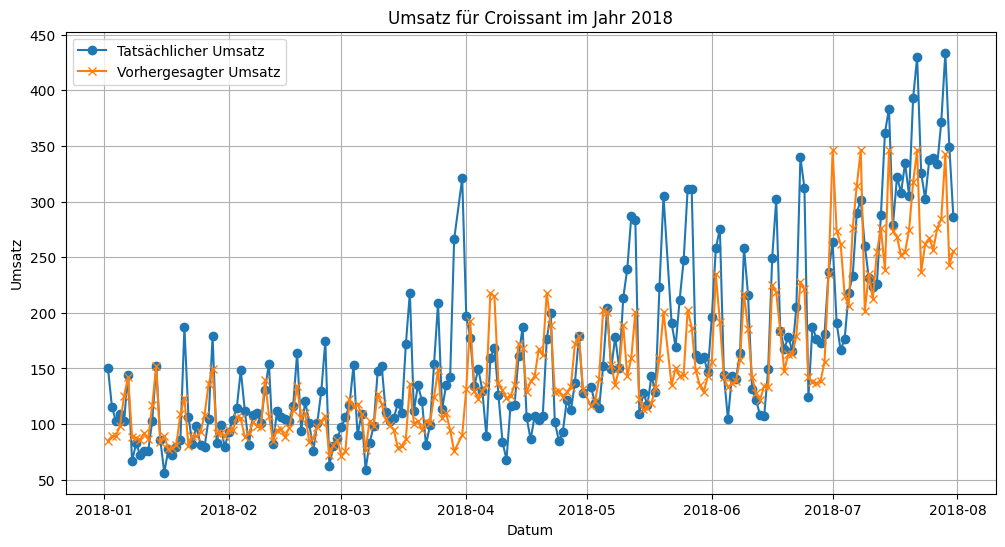

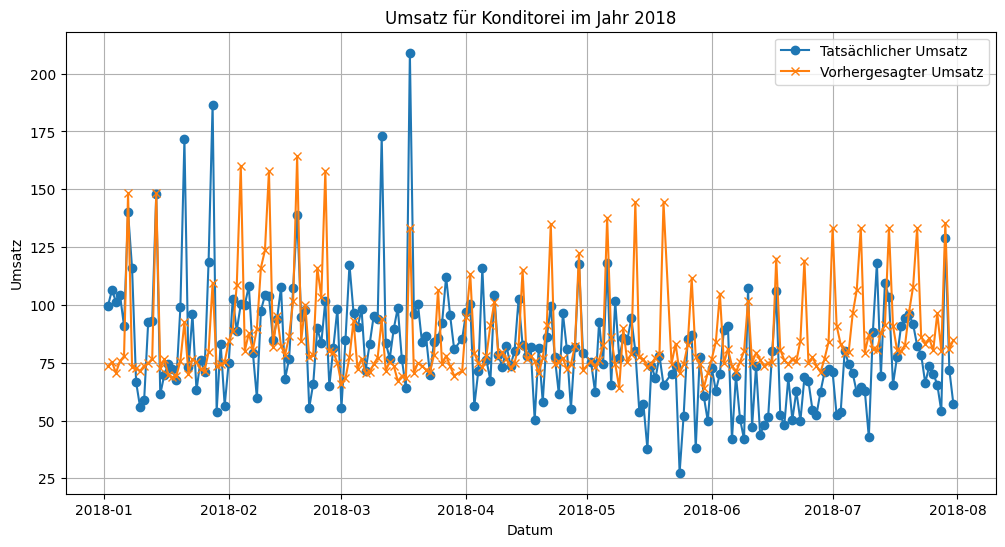

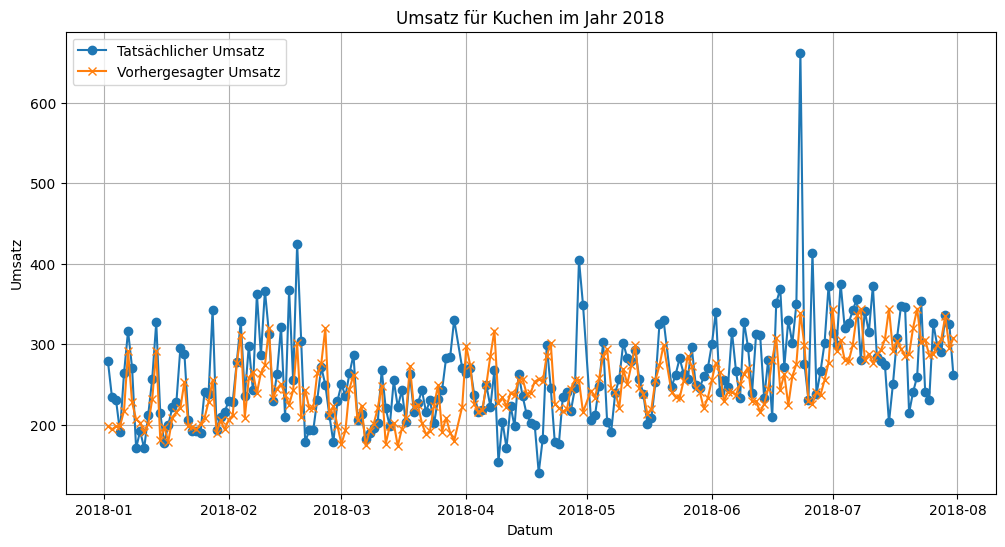

In [65]:
plot_yearly_sales(val_predictions_df)